In [1]:
""" 
Simulation:
Demonstration of extracting long-term dynamical trends from a sequence. 
Methods include:
1) Performing DMD, and extracting N key dynamic modes post-hoc
2) Performing Streaming DMD (SDMD), and extracting N key dynamic modes post-hoc
3) Performing DMD/SDMD, but using an (incorrect) small number of modes N.
4) Performing TREK, by first preprocessing with spectral manipulation first to reduce data to rank N, and then performing SDMD
"""

%matplotlib notebook
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
compute_integral = scipy.integrate.trapz
from scipy.stats import ortho_group
import pickle
from scipy.fft import fft2, fftfreq, ifft2

In [ ]:
# Requires dmdtools library
# https://github.com/cwrowley/dmdtools

# However, this notebook uses a modified implementation of the above:
# https://gitlab.com/Brendan_Michael/dmdtools

# Please install and import as appropriate

In [2]:
from pydmd import DMD as batch_DMD
from dmdtools.streaming import StreamingDMD
from dmdtools.streamingtmd import StreamingTMD

In [3]:
# Reuse previous data and models for speedier evaluation (if avaliable)
load_data = False
load_models = False

In [4]:
'''
Generate the simulation dataset
'''
def generate_data(J, N, K):
    # 1) Select randomly N orthonormal complex vectors of dimension J>N
    W = ortho_group.rvs(dim=J)
    
    # 2) Construct M > N linear combinations of these bases
    U = list()
    for _ in range(M):
        u_m = 0
        # Construct a linear combination of basis vectors with random coefficients
        for i in range(N):
            u_m += np.random.uniform(low=-100, high=100)*W[i,:]
        u_m = (u_m/np.linalg.norm(u_m))*np.sqrt(J) # Ensure ||u_m||_F = sqrt(J)
        U.append(u_m)
    U = np.array(U)    # Make into an array, where each u_m is a row
    print(U.shape)
    
    # 3) Construct the dynamics
    X = np.zeros((J, K),dtype='complex128') 
    f = np.linspace(-(1/dt)//2,(1/dt)//2,M)
    omega = f*(2*np.pi)
    print(f)
    for i,k in enumerate(timesteps):
        x = 0
        for d in range(M):
            x += U[d]*np.exp(1j*omega[d]*dt*i)
        X[:,i] = x 
    return X

def compute_dynamics(eigs,b):
    omega = np.log(eigs)
    vander = np.exp(np.outer(omega, range(K)))
    return vander * b[:, None]

In [5]:
'''
Parameters for the simulation
'''
K = 15000     # Number of measurements
J = 12000     # Dimensionality of each measurement
N = 101       # Number of low-rank spatial (POD) modes
M = 101       # Number of spectral components
dt = 0.01     # Sampling period

timesteps = np.linspace(0,K*dt,K)

In [6]:
'''
Generate some data, or load previous
'''
if load_data:
    print('Loading data')
    X = pickle.load(open("Sim_X.pickle", "rb"))
else:
    print('Generating new data')
    np.random.seed(1)
    X = generate_data(J,N,K)
    pickle.dump(X,open("Sim_X_new.pickle", "wb"))

Loading data


In [7]:
'''
Apply FFT to select only spectral components of X, given task-relevant infomation in Tau
'''
starttime = time.time()
xf = fftfreq(K, dt) # List of all freqs.
Tau = [-1,1] # Frequencies to keep, set a priori
y = fft2(X.T) # Compute fft

# Remove frequencies that are irrelevant
y[list(set(range(len(xf)))- (set([np.where(xf==w)[0][0] for w in Tau])))] = 0 # Remove those not in the list

Xfft = ifft2(y).T # Convert back to time domain
print('FFT took: {}s'.format(time.time()-starttime))

FFT took: 7.255885124206543s


In [8]:
'''
Approximate the number of spatial (POD) modes as a DMD preprocessing step
A standard approach, from Clainche et. al. Higher Order Dynamic Mode Decomposition, (SIAM), 2017
'''
def find_modes(V,tol=1e-16):
    starttime=time.time()
    _, s, _ = np.linalg.svd(V, full_matrices=False)
    rank = int(np.where(np.array([sum(s[r:]**2)/sum(s[:r]**2) for r in range(1,len(s)+1)])<=tol)[0][0])+1
    print('Finding N via SVD took: {}s'.format(time.time()-starttime))
    return rank
    
# For standard X, find N via SVD
max_rank_standard = find_modes(X)
print(max_rank_standard)

# For FFT processed X, use the number of desired frequencies
max_rank_fft = len(Tau)
print(max_rank_fft)

101
2


In [9]:
'''
Load or train the models
'''
if load_models:
    print('Load pretrained models')
    BDMD = pickle.load(open("Sim_BDMD_{}.pickle".format(max_rank_standard), "rb"))
    SDMD = pickle.load(open("Sim_SDMD_{}.pickle".format(max_rank_standard), "rb"))
    BDMD_low_rank = pickle.load(open("Sim_BDMD_{}.pickle".format(max_rank_fft), "rb"))
    SDMD_low_rank = pickle.load(open("Sim_SDMD_{}.pickle".format(max_rank_fft), "rb"))
    TREK_BDMD = pickle.load(open("Sim_TREK_BDMD_{}.pickle".format(max_rank_fft), "rb"))
    TREK_SDMD = pickle.load(open("Sim_TREK_SDMD_{}.pickle".format(max_rank_fft), "rb"))
else: 
    print('Learning models')
    
    # Compute models using the standard data
    # 1) Batch DMD      - BDMD
    # 2) Streaming DMD  - SDMD
    starttime=time.time()
    BDMD = batch_DMD(svd_rank=max_rank_standard,exact=True)
    BDMD.fit(X)
    print('BDMD Time taken: {}'.format(time.time()-starttime))

    starttime=time.time()
    SDMD = StreamingDMD(max_rank_standard,ngram=5)
    for ns in range(K-1):
        SDMD.update(X[:,ns], X[:,ns+1])
    print('SDMD Time taken: {}'.format(time.time()-starttime))

    # Compute models using the FFT data
    # 3) Batch DMD      - TREK_BDMD_
    # 4) Streaming DMD  - TREK_SDMD_
    starttime=time.time()
    TREK_BDMD_ = batch_DMD(svd_rank=max_rank_fft,exact=True)
    TREK_BDMD_.fit(Xfft)
    print('BDMD FFT Time taken: {}'.format(time.time()-starttime))

    starttime=time.time()
    TREK_SDMD_ = StreamingDMD(max_rank_fft,ngram=5)
    for ns in range(K-1):
        TREK_SDMD_.update(Xfft[:,ns], Xfft[:,ns+1])
    print('SDMD FFT Time taken: {}'.format(time.time()-starttime))
    
    # Also compute rank-2 models (without FFT), to demonstrate the problems with just choosing fewer modes
    # 1) Batch DMD      - BDMD
    # 2) Streaming DMD  - SDMD
    starttime=time.time()
    BDMD_low_rank = batch_DMD(svd_rank=max_rank_fft,exact=True)
    BDMD_low_rank.fit(X)
    print('BDMD Time taken: {}'.format(time.time()-starttime))

    starttime=time.time()
    SDMD_low_rank = StreamingDMD(max_rank_fft,ngram=5)
    for ns in range(K-1):
        SDMD_low_rank.update(X[:,ns], X[:,ns+1])
    print('SDMD Time taken: {}'.format(time.time()-starttime))
    
    pickle.dump(BDMD,open("Sim_BDMD_{}_new.pickle".format(max_rank_standard), "wb"))
    pickle.dump(SDMD,open("Sim_SDMD_{}_new.pickle".format(max_rank_standard), "wb"))
    pickle.dump(TREK_BDMD_,open("Sim_TREK_BDMD_{}_new.pickle".format(max_rank_fft), "wb"))
    pickle.dump(TREK_SDMD_,open("Sim_TREK_SDMD_{}_new.pickle".format(max_rank_fft), "wb"))
    pickle.dump(BDMD_low_rank,open("Sim_BDMD_{}_new.pickle".format(max_rank_fft), "wb"))
    pickle.dump(SDMD_low_rank,open("Sim_SDMD_{}_new.pickle".format(max_rank_fft), "wb"))

Load pretrained models


In [10]:
'''
Compute the modes and organise
'''
BDMD_modes, BDMD_eigs = BDMD.modes, BDMD.eigs
SDMD_modes, SDMD_eigs = SDMD.compute_modes()

BDMD_low_rank_modes, BDMD_low_rank_eigs = BDMD_low_rank.modes, BDMD_low_rank.eigs
SDMD_low_rank_modes, SDMD_low_rank_eigs = SDMD_low_rank.compute_modes()

TREK_BDMD_modes, TREK_BDMD_eigs = TREK_BDMD.modes, TREK_BDMD.eigs
TREK_SDMD_modes, TREK_SDMD_eigs = TREK_SDMD.compute_modes()

In [11]:
'''
Compute amplitudes and power for each model's modes
'''
BDMD_b = np.linalg.lstsq(BDMD_modes, X[:,0], rcond=None)[0]
BDMD_power = BDMD_eigs.imag*abs(BDMD_b)*2
SDMD_b = np.linalg.lstsq(SDMD_modes, X[:,0], rcond=None)[0]
SDMD_power = SDMD_eigs.imag*abs(SDMD_b)*2

BDMD_low_rank_b = np.linalg.lstsq(BDMD_low_rank_modes, X[:,0], rcond=None)[0]
BDMD_low_rank_power = BDMD_low_rank_eigs.imag*abs(BDMD_low_rank_b)*2
SDMD_low_rank_b = np.linalg.lstsq(SDMD_low_rank_modes, X[:,0], rcond=None)[0]
SDMD_low_rank_power = SDMD_low_rank_eigs.imag*abs(SDMD_low_rank_b)*2

TREK_BDMD_b = np.linalg.lstsq(TREK_BDMD_modes, Xfft[:,0], rcond=None)[0]
TREK_BDMD_power = TREK_BDMD_eigs.imag*abs(TREK_BDMD_b)*2
TREK_SDMD_b = np.linalg.lstsq(TREK_SDMD_modes, Xfft[:,0], rcond=None)[0]
TREK_SDMD_power = TREK_SDMD_eigs.imag*abs(TREK_SDMD_b)*2

<IPython.core.display.Javascript object>


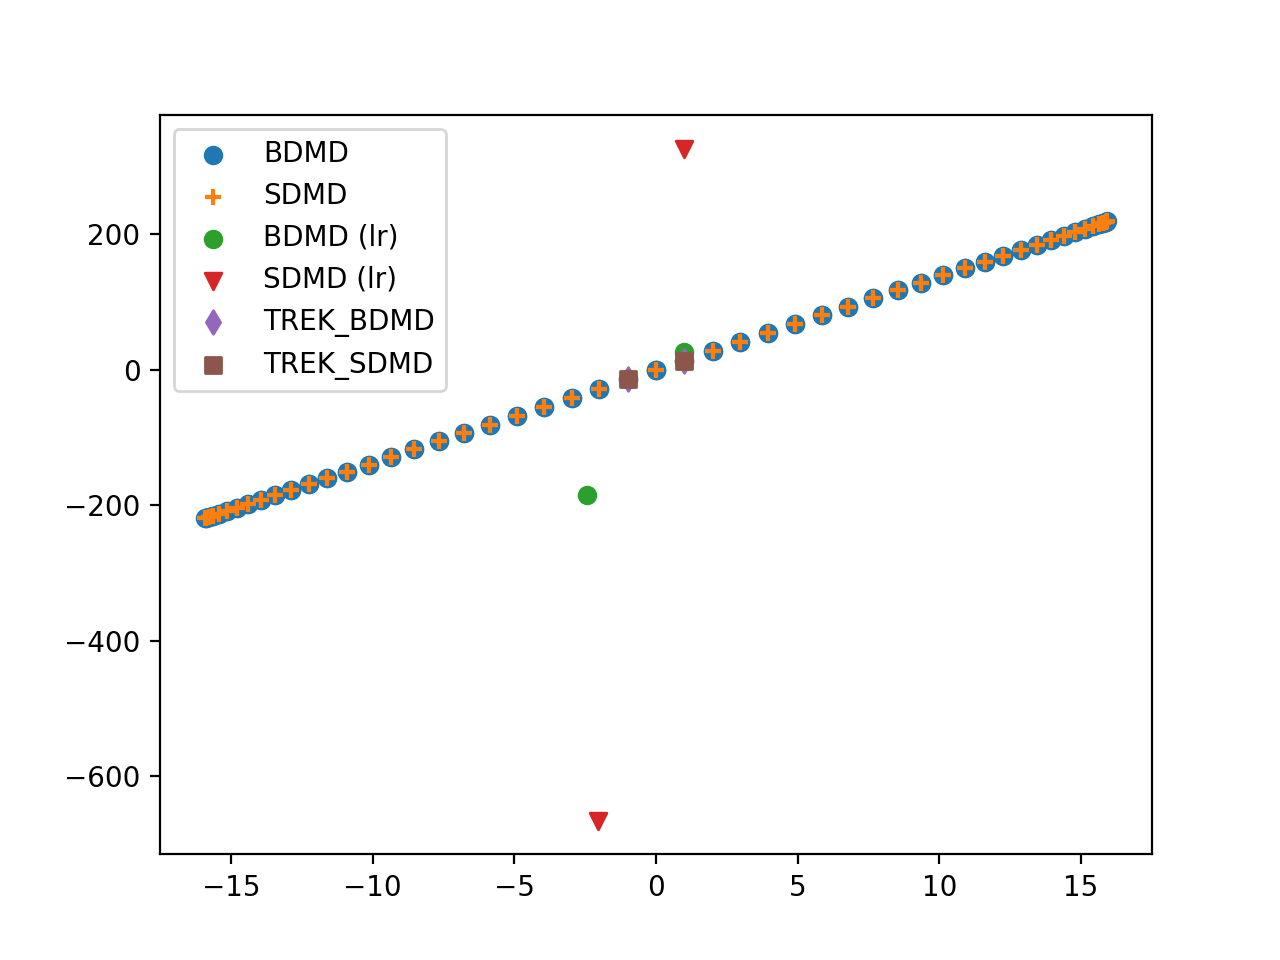

In [12]:
'''
Visualise the spectral components, to see how each method performs
'''
fig = plt.figure()
plt.scatter(BDMD_eigs.imag/dt/(2*np.pi),BDMD_power,label = 'BDMD')
plt.scatter(SDMD_eigs.imag/dt/(2*np.pi),SDMD_power,label = 'SDMD',marker='+')

plt.scatter(BDMD_low_rank_eigs.imag/dt/(2*np.pi),BDMD_low_rank_power,label = 'BDMD (lr)')
plt.scatter(SDMD_low_rank_eigs.imag/dt/(2*np.pi),SDMD_low_rank_power,label = 'SDMD (lr)',marker='v')

plt.scatter(TREK_BDMD_eigs.imag/dt/(2*np.pi),TREK_BDMD_power,label = 'TREK_BDMD',marker='d')
plt.scatter(TREK_SDMD_eigs.imag/dt/(2*np.pi),TREK_SDMD_power,label = 'TREK_SDMD',marker='s')

plt.legend(loc='best')

BDMD: 100/101 eigs retained
SDMD: 100/100 eigs retained
TREK_BDMD_: 2/2 eigs retained
TREK_SDMD_: 2/2 eigs retained
BDMD_low_rank: 2/2 eigs retained
SDMD_low_rank: 2/2 eigs retained


<IPython.core.display.Javascript object>


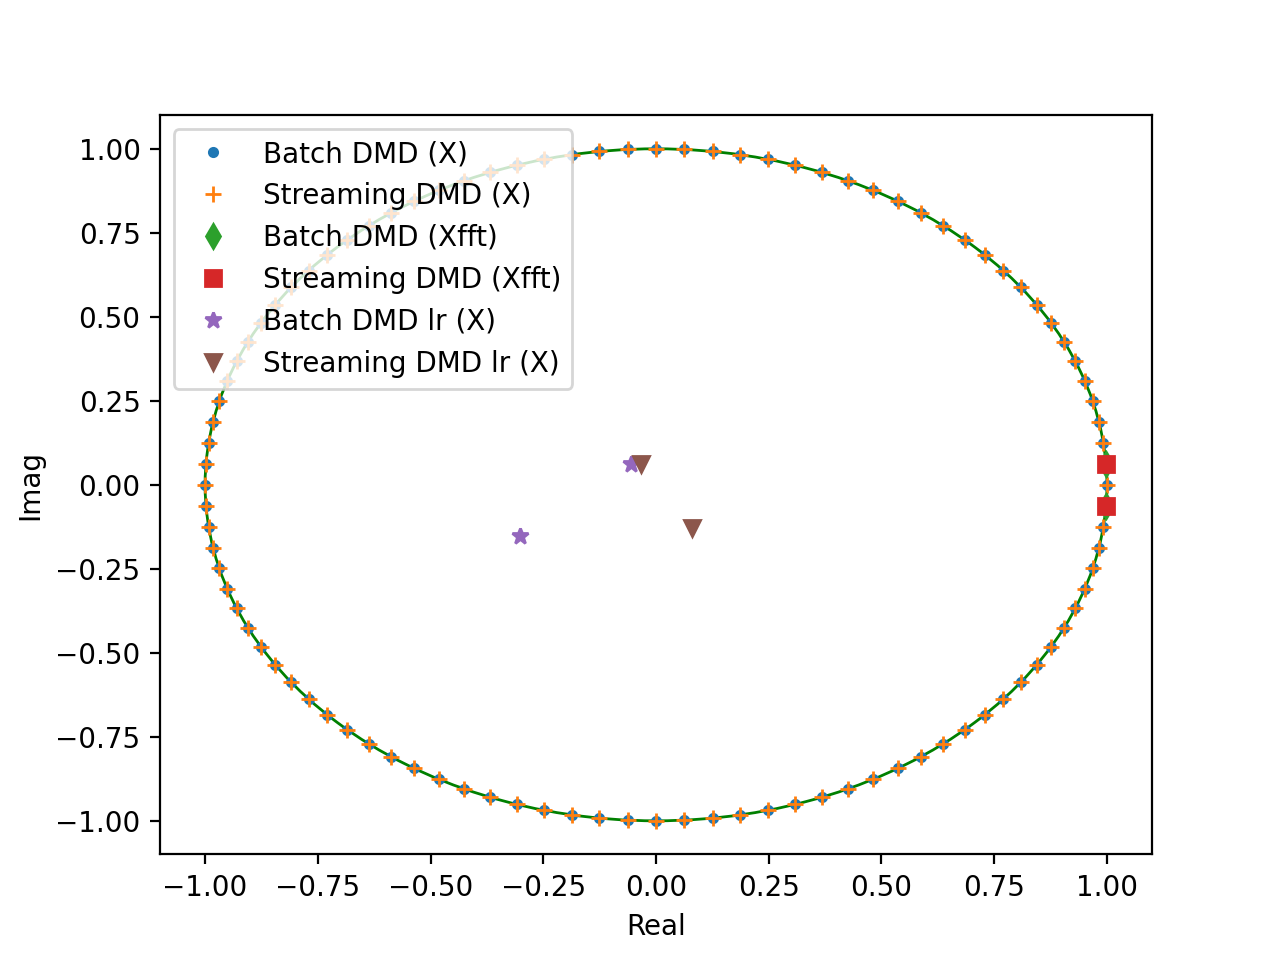

In [13]:
# Remove components with low amplitude if needed (not needed for the simulation in the paper) 
sigma = 10e-6 # Threshold, again based on Clainche

# Select a subset of spectral modes M based on the amplitudes
# This is a horrible line of code. Basically, we sort the (absolute real) amplitudes in descending order
get_indices = lambda b : np.argsort(abs(b.real))[::-1][np.logical_not(((abs(b.real)[np.argsort(abs(b.real))[::-1]])/np.max(abs(b.real)))<sigma)]

# Then, we normalise by the biggest one, and select those that are above a threshold
BDMD_indices = get_indices(BDMD_b)
SDMD_indices = get_indices(SDMD_b) 

BDMD_low_rank_indices = get_indices(BDMD_low_rank_b) 
SDMD_low_rank_indices = get_indices(SDMD_low_rank_b) 

TREK_BDMD_indices = get_indices(TREK_BDMD_b) 
TREK_SDMD_indices = get_indices(TREK_SDMD_b) 

print('BDMD: {}/{} eigs retained'.format(len(BDMD_indices),len(BDMD_eigs)))
print('SDMD: {}/{} eigs retained'.format(len(SDMD_indices),len(SDMD_eigs)))
print('TREK_BDMD_: {}/{} eigs retained'.format(len(TREK_BDMD_indices),len(TREK_BDMD_eigs)))
print('TREK_SDMD_: {}/{} eigs retained'.format(len(TREK_SDMD_indices),len(TREK_SDMD_eigs)))
print('BDMD_low_rank: {}/{} eigs retained'.format(len(BDMD_low_rank_indices),len(BDMD_low_rank_eigs)))
print('SDMD_low_rank: {}/{} eigs retained'.format(len(SDMD_low_rank_indices),len(SDMD_low_rank_eigs)))

# Visualise the eigenvalues that are kept 

fig, ax = plt.subplots()
plt.plot(BDMD_eigs.real[BDMD_indices], BDMD_eigs.imag[BDMD_indices],'.',label='Batch DMD (X)')
plt.plot(SDMD_eigs.real[SDMD_indices], SDMD_eigs.imag[SDMD_indices], '+',label='Streaming DMD (X)')
plt.plot(TREK_BDMD_eigs[TREK_BDMD_indices].real, TREK_BDMD_eigs.imag[TREK_BDMD_indices], 'd',label='Batch DMD (Xfft)')
plt.plot(TREK_SDMD_eigs.real[TREK_SDMD_indices], TREK_SDMD_eigs.imag[TREK_SDMD_indices], 's',label='Streaming DMD (Xfft)')
plt.plot(BDMD_low_rank_eigs.real[BDMD_low_rank_indices], BDMD_low_rank_eigs.imag[BDMD_low_rank_indices],'*',label='Batch DMD lr (X)')
plt.plot(SDMD_low_rank_eigs.real[SDMD_low_rank_indices], SDMD_low_rank_eigs.imag[SDMD_low_rank_indices], 'v',label='Streaming DMD lr (X)')
ax.add_patch(plt.Circle((0, 0), 1, color='g',fill=False))
plt.legend(loc=2)
plt.xlabel('Real')
plt.ylabel('Imag')
plt.show()

<IPython.core.display.Javascript object>


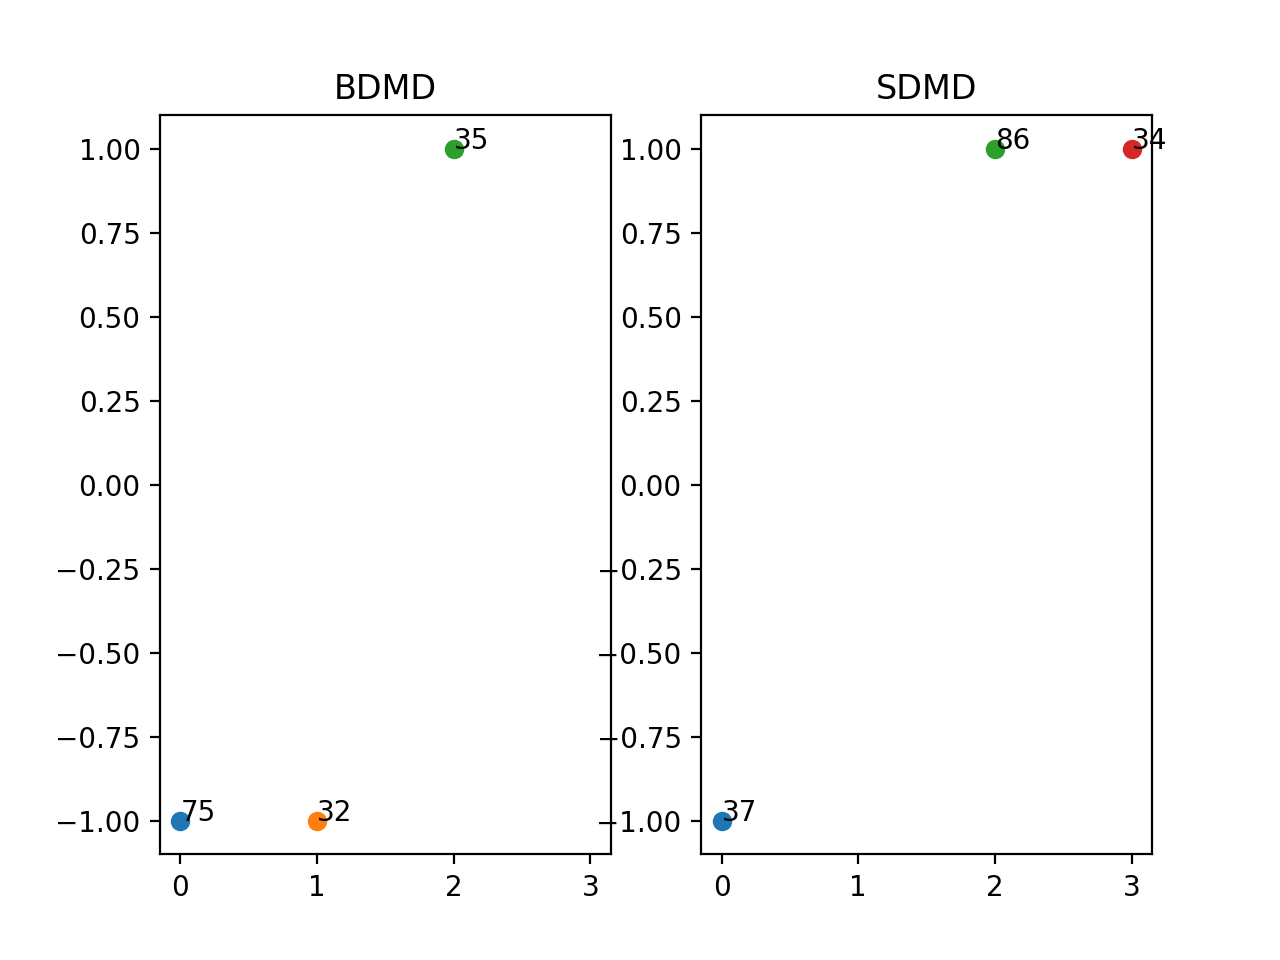

In [14]:
'''
Identify which dynamic mode corresponds to the task-relevant frequencies in Tau
This is the post-hoc analysis required for standard DMD application
'''
def find_n_closest_indices(data, value, n):
    indices = range(max_rank_standard-1)
    index_list = list()
    for i in range(n):
        index_list.append(abs(data[indices] - value).argmin())
        indices = np.array(list(set(indices).difference(set(index_list))))
    return index_list

# Plot all the relevant ones
fig = plt.figure()
plt.subplot(121)
long_term_indices = np.array([find_n_closest_indices(BDMD_eigs.imag/dt/(2*np.pi), t,2) for t in Tau]).flatten()
plt.title('BDMD')
for i,index in enumerate(long_term_indices):
    plt.scatter(i,BDMD_eigs.imag[index]/dt/(2*np.pi),label=index)
    plt.text(i,BDMD_eigs.imag[index]/dt/(2*np.pi),index)
plt.ylim([-1.1,1.1])

plt.subplot(122)
long_term_indices = np.array([find_n_closest_indices(SDMD_eigs.imag/dt/(2*np.pi), t,2) for t in Tau]).flatten()
plt.title('SDMD')
for i,index in enumerate(long_term_indices):
    plt.scatter(i,SDMD_eigs.imag[index]/dt/(2*np.pi),label=index)
    plt.text(i,SDMD_eigs.imag[index]/dt/(2*np.pi),index)
plt.ylim([-1.1,1.1])

# From these, choose the indices that show the long term trends 
BDMD_long_term_indices = [75]
SDMD_long_term_indices = [86]

In [15]:
'''
Compute the (full) dynamics and reconstruction for each method
'''
def get_reconstruction(modes,eigs,b,indices):
    long_term_dynamics = compute_dynamics(eigs[indices],b[indices])
    long_term_reconstruction = modes[:,indices].dot(long_term_dynamics)
    return long_term_reconstruction
    
BDMD_reconstruction = get_reconstruction(BDMD_modes,BDMD_eigs,BDMD_b,BDMD_indices)
SDMD_reconstruction = get_reconstruction(SDMD_modes,SDMD_eigs,SDMD_b,SDMD_indices)

BDMD_low_rank_reconstruction = get_reconstruction(BDMD_low_rank_modes,BDMD_low_rank_eigs,BDMD_low_rank_b,BDMD_low_rank_indices)
SDMD_low_rank_reconstruction = get_reconstruction(SDMD_low_rank_modes,SDMD_low_rank_eigs,SDMD_low_rank_b,SDMD_low_rank_indices)

TREK_BDMD_reconstruction = get_reconstruction(TREK_BDMD_modes,TREK_BDMD_eigs,TREK_BDMD_b,TREK_BDMD_indices)
TREK_SDMD_reconstruction = get_reconstruction(TREK_SDMD_modes,TREK_SDMD_eigs,TREK_SDMD_b,TREK_SDMD_indices)

'''
Compute a reconstruction using only the long-term dynamics (Task-relevant selection from Fig.3 in paper)
'''
BDMD_long_term_reconstruction = get_reconstruction(BDMD_modes,BDMD_eigs,BDMD_b,BDMD_long_term_indices)
SDMD_long_term_reconstruction = get_reconstruction(SDMD_modes,SDMD_eigs,SDMD_b,SDMD_long_term_indices)

In [17]:
'''
Compute the integral over each sequence to visualise a dynamics estimated as a 1D line
'''

X_int = compute_integral(X.T)
Xfft_int = compute_integral(Xfft.T)

BDMD_int = compute_integral(BDMD_reconstruction.T)
SDMD_int = compute_integral(SDMD_reconstruction.T)

BDMD_long_term_int = compute_integral(BDMD_long_term_reconstruction.T)
SDMD_long_term_int = compute_integral(SDMD_long_term_reconstruction.T)

BDMD_low_rank_int = compute_integral(BDMD_low_rank_reconstruction.T)
SDMD_low_rank_int = compute_integral(SDMD_low_rank_reconstruction.T)

TREK_BDMD_int = compute_integral(TREK_BDMD_reconstruction.T)
TREK_SDMD_int = compute_integral(TREK_SDMD_reconstruction.T)

# Normalise to [-1,1], we we are interested only in the trends, not the amplitude
Xfft_int_norm = 2.*(Xfft_int - np.min(Xfft_int))/np.ptp(Xfft_int)-1

BDMD_long_term_int_norm = 2.*(BDMD_long_term_int - np.min(BDMD_long_term_int))/np.ptp(BDMD_long_term_int)-1
SDMD_long_term_int_norm = 2.*(SDMD_long_term_int - np.min(SDMD_long_term_int))/np.ptp(SDMD_long_term_int)-1
SDMD_long_term_int_norm = -SDMD_long_term_int_norm# flip right way up due to normalization

BDMD_low_rank_int_norm = 2.*(BDMD_low_rank_int - np.min(BDMD_low_rank_int))/np.ptp(BDMD_low_rank_int)-1
SDMD_low_rank_int_norm = 2.*(SDMD_low_rank_int - np.min(SDMD_low_rank_int))/np.ptp(SDMD_low_rank_int)-1

TREK_SDMD_int_norm = 2.*(TREK_SDMD_int - np.min(TREK_SDMD_int))/np.ptp(TREK_SDMD_int)-1

<IPython.core.display.Javascript object>


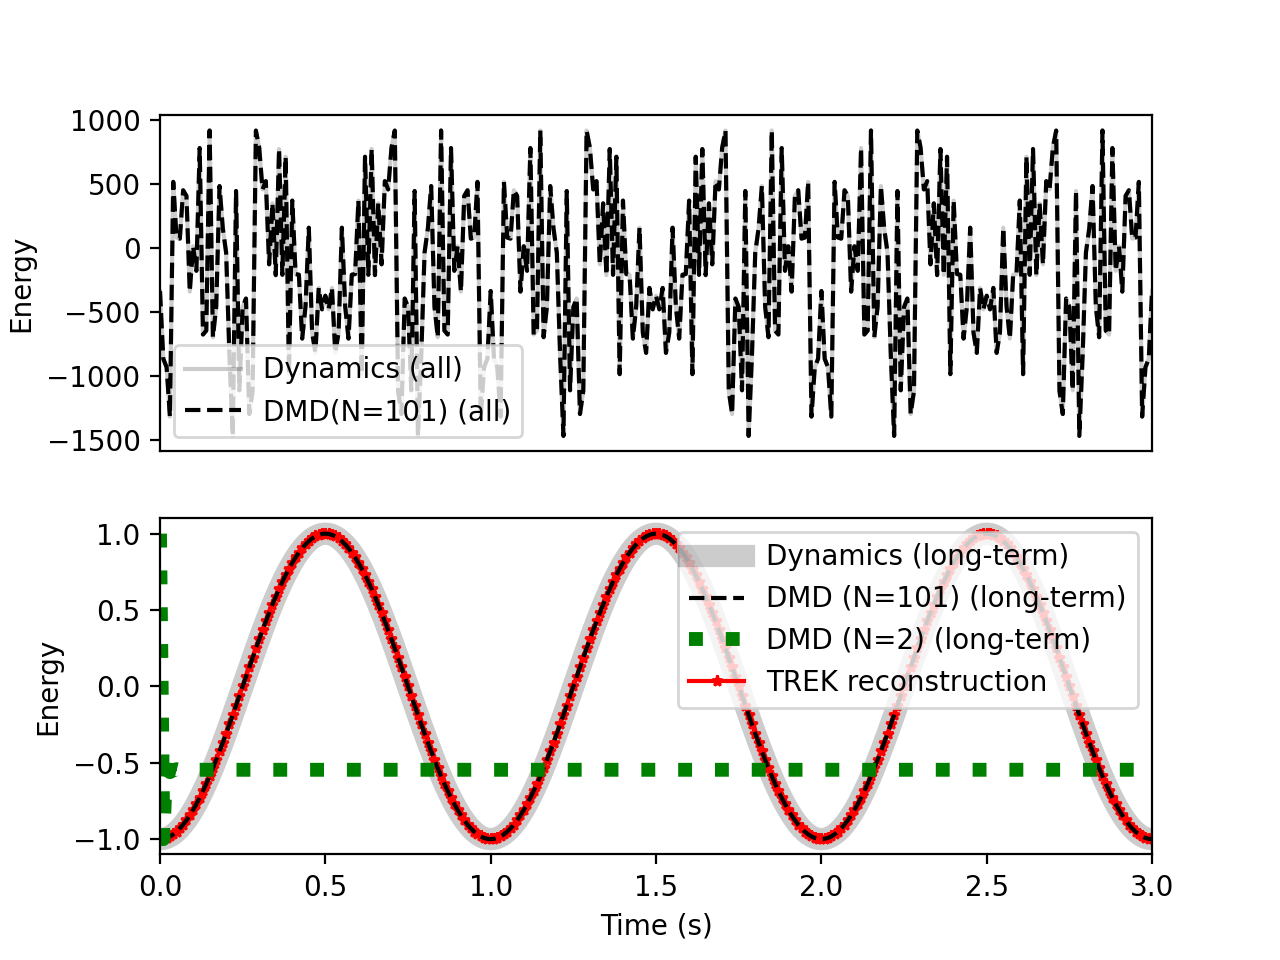

/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packag

In [53]:
'''
Plot the reconstructions
'''
fig = plt.figure()
plt.subplot(211)
plt.plot(timesteps,X_int,color='k',alpha=0.2,label=r'Dynamics (all)')
plt.plot(timesteps,BDMD_int,'--k',label=r'DMD(N=101) (all)')



plt.xlim([0,3])
plt.legend(loc=3)
plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel('Energy')

plt.subplot(212)
plt.plot(timesteps,Xfft_int_norm,color='k',alpha=0.2,linewidth=8,label=r'Dynamics (long-term)')
plt.plot(timesteps,TREK_SDMD_int_norm,'-*r',markersize=4,label=r'TREK reconstruction')
plt.plot(timesteps,BDMD_long_term_int_norm,'--k',label=r'DMD (N=101) (long-term)')
plt.plot(timesteps,BDMD_low_rank_int_norm,':g',linewidth=5,label=r'DMD (N=2) (long-term)')

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,2,3,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=1)
plt.xlim([0,3])
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.savefig('sim_results.pdf')

In [23]:
'''
Compute Errors for Table. 2
'''
mse = lambda x1,x2 : np.sum((x1.real-x2.real)**2)/K

# Compute the error between each prediction against the original sequence
DMD_101_error = mse(X_int,BDMD_int)
SDMD_101_error = mse(X_int,SDMD_int)
DMD_2_error = mse(X_int,BDMD_low_rank_int)
SDMD_2_error = mse(X_int,SDMD_low_rank_int)
TREK_2_error_all = mse(X_int,TREK_SDMD_int)
print(DMD_101_error)
print(SDMD_101_error)
print(DMD_2_error)
print(SDMD_2_error)
print(TREK_2_error_all)
print('')

# Compute the error between the task-relevant components of each prediction, against the long-term component of the sequence
# In the case of standard DMD/SDMD, this the post-hoc extraction as outlined in Fig. 3 of the paper
# In the case of TREK, this is just the model output
DMD_101_error = mse(Xfft_int_norm,BDMD_long_term_int_norm)
SDMD_101_error = mse(Xfft_int_norm,SDMD_long_term_int_norm) 
DMD_2_error = mse(Xfft_int_norm,BDMD_low_rank_int_norm)
SDMD_2_error = mse(Xfft_int_norm,SDMD_low_rank_int_norm)
TREK_2_error_all = mse(Xfft_int_norm,TREK_SDMD_int_norm)
print(DMD_101_error)
print(SDMD_101_error)
print(DMD_2_error)
print(SDMD_2_error)
print(TREK_2_error_all)

2.9386817831644374e-16
1.4812800868077417e-15
435776.94844925235
435711.71110565326
435761.1648188966

1.0170420692888281e-19
9.122648045005859e-20
0.7982970539897102
1.4904951387016308
1.1863072459752982e-20


<IPython.core.display.Javascript object>


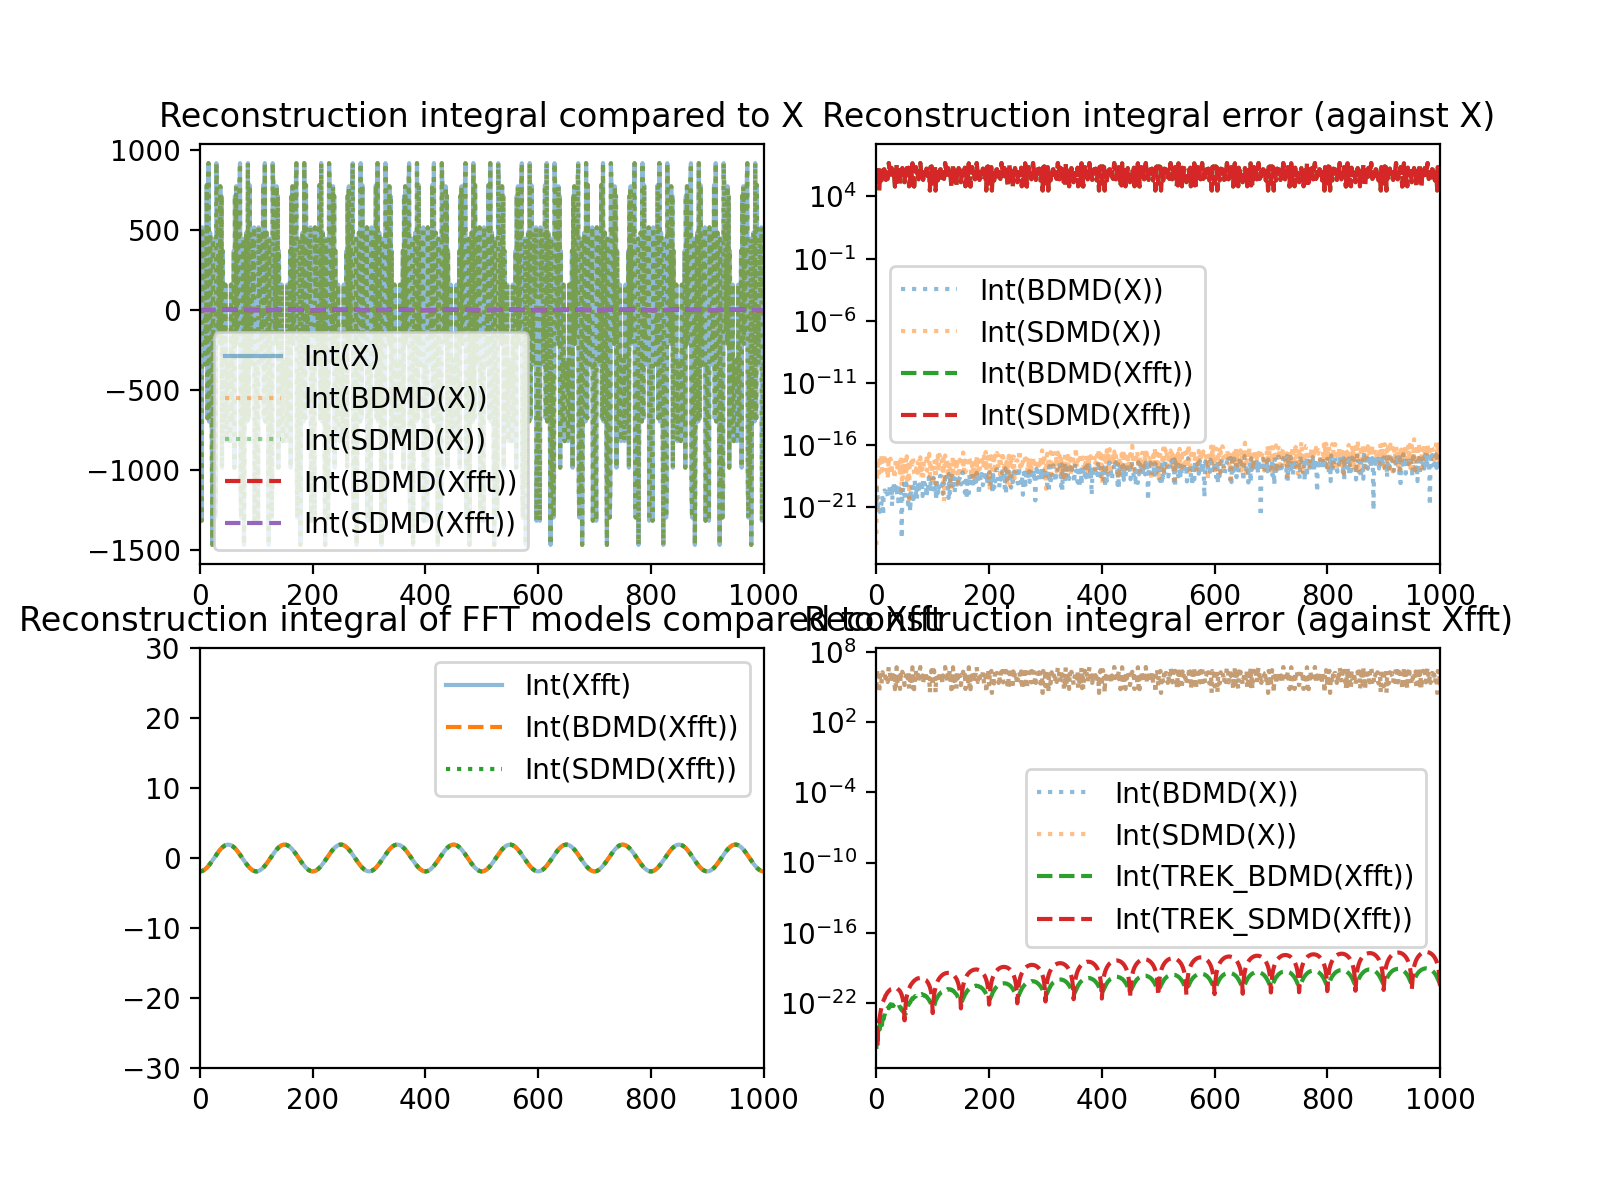

/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/rl-gtune/anaconda3/envs/env_furnace_forecast/lib/python3.7/site-packag

(0.0, 1000.0)

In [20]:
# Plot a larger reconstruction, and errors
fig = plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(X_int,alpha=0.5,label='Int(X)')
plt.plot(BDMD_int,':',alpha=0.5,label='Int(BDMD(X))')
plt.plot(SDMD_int,':',alpha=0.5,label='Int(SDMD(X))')
plt.plot(TREK_BDMD_int,'--',label='Int(BDMD(Xfft))')
plt.plot(TREK_SDMD_int,'--',label='Int(SDMD(Xfft))')
plt.legend()
plt.title('Reconstruction integral compared to X')
plt.xlim([0,1000])

plt.subplot(222)
plt.plot(abs(X_int-BDMD_int)**2,':',alpha=0.5,label='Int(BDMD(X))')
plt.plot(abs(X_int-SDMD_int)**2,':',alpha=0.5,label='Int(SDMD(X))')
plt.plot(abs(X_int-TREK_BDMD_int)**2,'--',label='Int(BDMD(Xfft))')
plt.plot(abs(X_int-TREK_SDMD_int)**2,'--',label='Int(SDMD(Xfft))')
plt.legend()
plt.yscale('log')
plt.title('Reconstruction integral error (against X)')
plt.xlim([0,1000])

plt.subplot(223)
plt.plot(Xfft_int,alpha=0.5,label='Int(Xfft)')
plt.plot(TREK_BDMD_int,'--',label='Int(BDMD(Xfft))')
plt.plot(TREK_SDMD_int,':',label='Int(SDMD(Xfft))')
plt.legend()
plt.title('Reconstruction integral of FFT models compared to Xfft')
plt.ylim([-30,30])
plt.xlim([0,1000])

plt.subplot(224)
plt.plot(abs(Xfft_int-BDMD_int)**2,':',alpha=0.5,label='Int(BDMD(X))')
plt.plot(abs(Xfft_int-SDMD_int)**2,':',alpha=0.5,label='Int(SDMD(X))')
plt.plot(abs(Xfft_int-TREK_BDMD_int)**2,'--',label='Int(TREK_BDMD(Xfft))')
plt.plot(abs(Xfft_int-TREK_SDMD_int)**2,'--',label='Int(TREK_SDMD(Xfft))')
plt.legend()
plt.yscale('log')
plt.title('Reconstruction integral error (against Xfft)')
plt.xlim([0,1000])